In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/gdrive')

# install libraries
!pip install mat73
!pip install git+https://github.com/gatagat/lap.git

Mounted at /gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gatagat/lap.git to /tmp/pip-req-build-2qp6ftjj
  Running command git clone -q https://github.com/gatagat/lap.git /tmp/pip-req-build-2qp6ftjj
  Created wheel for lap: filename=lap-0.5.dev0-cp37-cp37m-linux_x86_64.whl size=1588076 sha256=4e6edc562c3f7b7045baf8e9be5a20ada7d6aa155b946a8b629eb4dac7e5b1bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-zuic_n3f/wheels/71/21/74/2481f0bf036621beab03f565b5e4af312b9933915d16aab179
Successfully built lap


In [2]:
import os
import lap
import mat73
import torch
import pickle
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from scipy.spatial.distance import cdist

In [25]:
pyfile = "/gdrive/My Drive/TReNDS/MISA/torch-misa/recovered_sources/res_mmiva_W.p"
with open(pyfile, 'rb') as handle:
    res = pickle.load(handle)

source_py = res['recovered_sources']
source_mat = mat73.loadmat("/gdrive/My Drive/TReNDS/MISA/torch-misa/recovered_sources/data1_Y.mat")['Y']

source_py_smri = source_py[0]
source_py_fmri = source_py[1]
source_py_dmri = source_py[2]

source_mat_smri = source_mat[0]
source_mat_fmri = source_mat[1]
source_mat_dmri = source_mat[2]

In [6]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [26]:
corr_mat_smri_fmri = correlation(source_mat_smri, source_mat_fmri)
corr_mat_smri_dmri = correlation(source_mat_smri, source_mat_dmri)
corr_mat_fmri_dmri = correlation(source_mat_fmri, source_mat_dmri)

corr_py_smri_fmri = correlation(source_py_smri.T, source_py_fmri.T)
corr_py_smri_dmri = correlation(source_py_smri.T, source_py_dmri.T)
corr_py_fmri_dmri = correlation(source_py_fmri.T, source_py_dmri.T)

In [8]:
corr_smri = correlation(source_py_smri.T, source_mat_smri)
corr_fmri = correlation(source_py_fmri.T, source_mat_fmri)
corr_dmri = correlation(source_py_dmri.T, source_mat_dmri)

(30, 30)

In [9]:
%time min_cost, row_assigns, col_assigns = lap.lapjv(1-np.abs(corr_smri), extend_cost=True)
print( col_assigns+1 )
print( np.arange(1, 31) )

print( np.arange(1, 31) )
print( row_assigns+1 )

CPU times: user 210 µs, sys: 1.83 ms, total: 2.04 ms
Wall time: 5.57 ms
[16 23 13 28  6 18  8 24 10  4 11 21 14  1 19 17 22  3 12 20 15 25 26  7
 27  2  9 29 30  5]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[14 26 18 10 30  5 24  7 27  9 11 19  3 13 21  1 16  6 15 20 12 17  2  8
 22 23 25  4 28 29]


In [10]:
corr_smri_new = corr_smri[col_assigns, :]
# corr_smri_new = corr_smri[:, row_assigns]
print(np.sum(np.abs(np.diag(corr_smri))), np.sum(np.abs(np.diag(corr_smri_new))))

1.9696195518543103 4.707829914548102


In [12]:
corr_smri_sorted_abs = np.abs( correlation(source_py_smri.T[col_assigns], source_mat_smri) )
# print(np.abs(np.diag(corr_smri_sorted_abs)))

ind = np.argsort(np.diag(corr_smri_sorted_abs))
corr_smri_sorted_abs = np.abs( correlation(source_py_smri.T[col_assigns][ind[::-1]], source_mat_smri[ind[::-1]]) )
# print(np.abs(np.diag(corr_smri_sorted_abs)))
# print(np.sum(np.abs(np.diag(corr_smri_sorted_abs))))

corr_fmri_sorted_abs = np.abs( correlation(source_py_fmri.T[col_assigns][ind[::-1]], source_mat_fmri[ind[::-1]]) )
corr_dmri_sorted_abs = np.abs( correlation(source_py_dmri.T[col_assigns][ind[::-1]], source_mat_dmri[ind[::-1]]) )

In [15]:
label_list = []
for i in range(1,31):
  label_list.append("SCV "+str(i))

python_label_list = [label_list[i] for i in col_assigns]
python_label_list = [python_label_list[i] for i in ind[::-1]]
matlab_label_list = [label_list[i] for i in ind[::-1]]

In [16]:
print(python_label_list)
print(matlab_label_list)

['SCV 24', 'SCV 29', 'SCV 17', 'SCV 13', 'SCV 8', 'SCV 26', 'SCV 20', 'SCV 22', 'SCV 11', 'SCV 1', 'SCV 23', 'SCV 15', 'SCV 16', 'SCV 18', 'SCV 10', 'SCV 28', 'SCV 5', 'SCV 7', 'SCV 3', 'SCV 2', 'SCV 14', 'SCV 27', 'SCV 25', 'SCV 21', 'SCV 6', 'SCV 4', 'SCV 9', 'SCV 12', 'SCV 19', 'SCV 30']
['SCV 8', 'SCV 28', 'SCV 16', 'SCV 3', 'SCV 7', 'SCV 23', 'SCV 20', 'SCV 17', 'SCV 11', 'SCV 14', 'SCV 2', 'SCV 21', 'SCV 1', 'SCV 6', 'SCV 9', 'SCV 4', 'SCV 30', 'SCV 24', 'SCV 18', 'SCV 26', 'SCV 13', 'SCV 25', 'SCV 22', 'SCV 12', 'SCV 5', 'SCV 10', 'SCV 27', 'SCV 19', 'SCV 15', 'SCV 29']


In [23]:
np.diag(corr_smri_sorted_abs)

array([0.29135065, 0.22879591, 0.22429658, 0.21612434, 0.20484436,
       0.20098038, 0.19138806, 0.18682914, 0.17915229, 0.17627677,
       0.17569713, 0.1642623 , 0.15748977, 0.15400067, 0.15155059,
       0.1495346 , 0.14711656, 0.14111045, 0.14039604, 0.1362169 ,
       0.1291413 , 0.12277189, 0.11869417, 0.1185031 , 0.11685783,
       0.11658006, 0.11643144, 0.11158991, 0.08518914, 0.05465762])

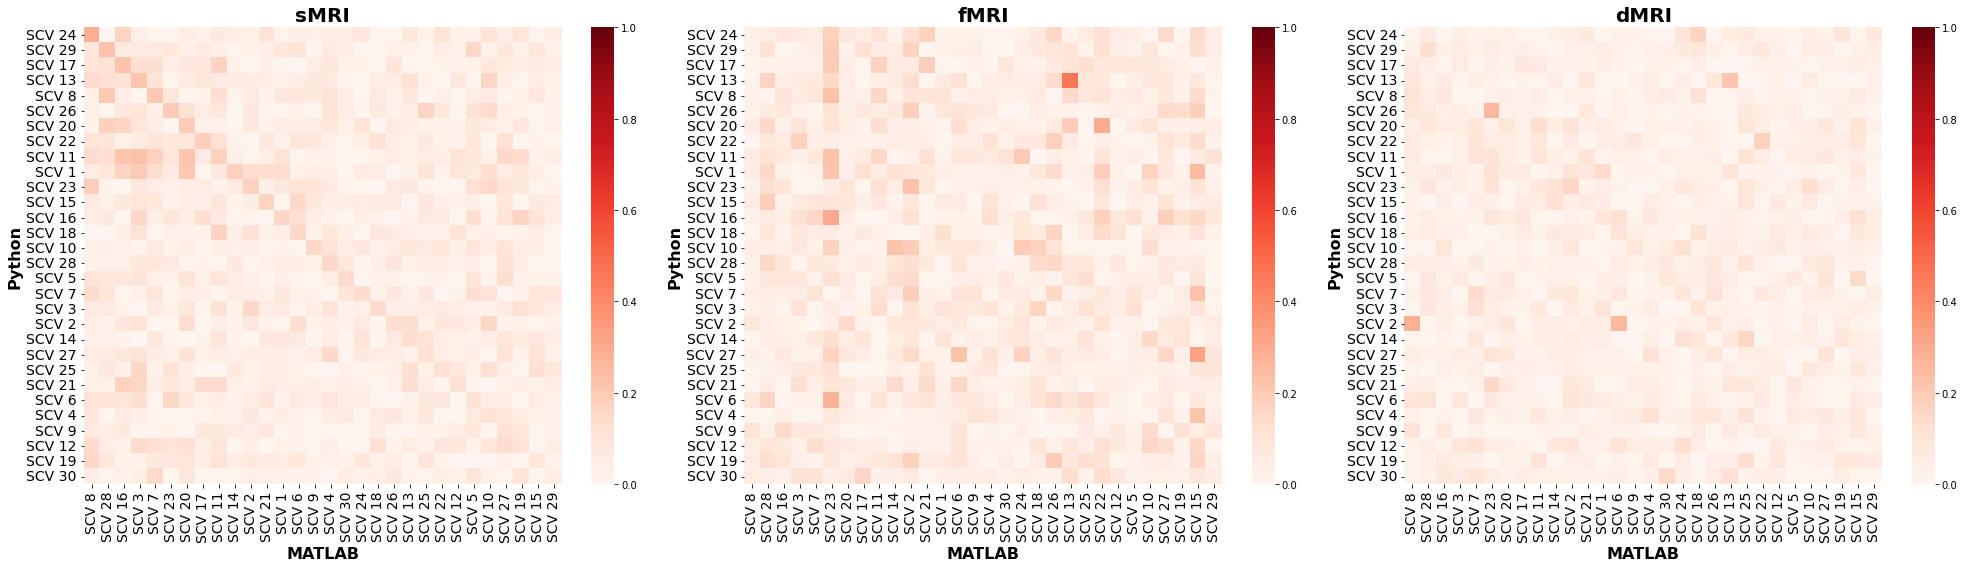

In [22]:
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
colormap_option = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28,8))

ticks = np.arange(0.5, 30.5, 1)
g1 = sns.heatmap(corr_smri_sorted_abs, cmap=colormap_option, vmin=0, vmax=1, yticklabels=python_label_list, xticklabels=matlab_label_list, ax=ax1)
g1.set_title("sMRI", fontsize=title_fontsize, fontweight="bold")
g1.set_xlabel("MATLAB", fontsize=label_fontsize, fontweight="bold")
g1.set_xticks(ticks)
g1.set_xticklabels(g1.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g1.set_ylabel("Python", fontsize=label_fontsize, fontweight="bold")
g1.set_yticks(ticks)
g1.set_yticklabels(g1.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g2 = sns.heatmap(corr_fmri_sorted_abs, cmap=colormap_option, vmin=0, vmax=1, yticklabels=python_label_list, xticklabels=matlab_label_list, ax=ax2)
g2.set_title("fMRI", fontsize=title_fontsize, fontweight="bold")
g2.set_xlabel("MATLAB", fontsize=label_fontsize, fontweight="bold")
g2.set_xticks(ticks)
g2.set_xticklabels(g2.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g2.set_ylabel("Python", fontsize=label_fontsize, fontweight="bold")
g2.set_yticks(ticks)
g2.set_yticklabels(g2.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g3 = sns.heatmap(corr_dmri_sorted_abs, cmap=colormap_option, vmin=0, vmax=1, yticklabels=python_label_list, xticklabels=matlab_label_list, ax=ax3)
g3.set_title("dMRI", fontsize=title_fontsize, fontweight="bold")
g3.set_xlabel("MATLAB", fontsize=label_fontsize, fontweight="bold")
g3.set_xticks(ticks)
g3.set_xticklabels(g3.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g3.set_ylabel("Python", fontsize=label_fontsize, fontweight="bold")
g3.set_yticks(ticks)
g3.set_yticklabels(g3.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

plt.tight_layout()
# plt.savefig("corr_recovered_sources.pdf", dpi=200)
# files.download("corr_recovered_sources.pdf") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

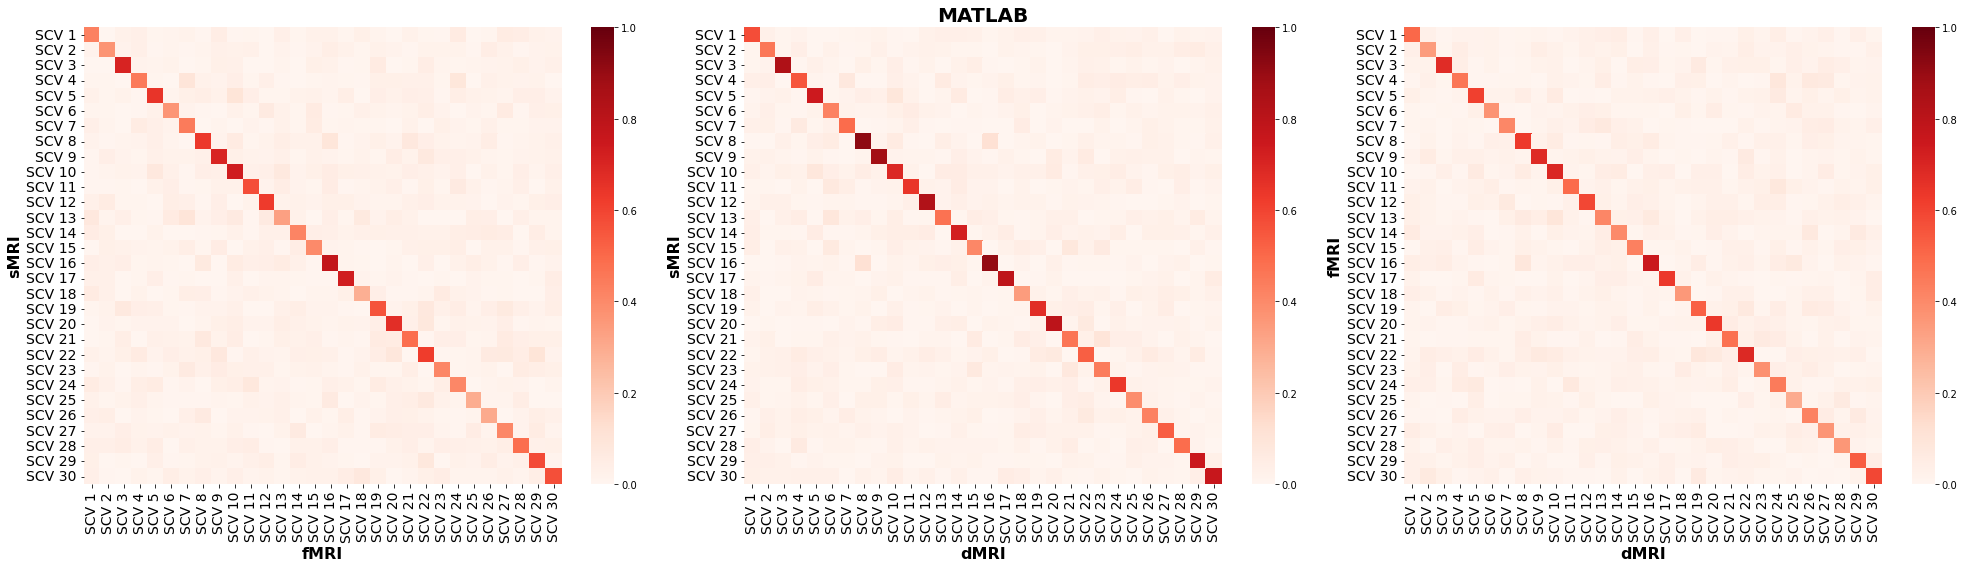

In [31]:
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
colormap_option = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28,8))

ticks = np.arange(0.5, 30.5, 1)
g1 = sns.heatmap(np.abs(corr_mat_smri_fmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax1)
# g1.set_title("MATLAB", fontsize=title_fontsize, fontweight="bold")
g1.set_xlabel("fMRI", fontsize=label_fontsize, fontweight="bold")
g1.set_xticks(ticks)
g1.set_xticklabels(g1.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g1.set_ylabel("sMRI", fontsize=label_fontsize, fontweight="bold")
g1.set_yticks(ticks)
g1.set_yticklabels(g1.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g2 = sns.heatmap(np.abs(corr_mat_smri_dmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax2)
g2.set_title("MATLAB", fontsize=title_fontsize, fontweight="bold")
g2.set_xlabel("dMRI", fontsize=label_fontsize, fontweight="bold")
g2.set_xticks(ticks)
g2.set_xticklabels(g2.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g2.set_ylabel("sMRI", fontsize=label_fontsize, fontweight="bold")
g2.set_yticks(ticks)
g2.set_yticklabels(g2.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g3 = sns.heatmap(np.abs(corr_mat_fmri_dmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax3)
# g3.set_title("MATLAB", fontsize=title_fontsize, fontweight="bold")
g3.set_xlabel("dMRI", fontsize=label_fontsize, fontweight="bold")
g3.set_xticks(ticks)
g3.set_xticklabels(g3.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g3.set_ylabel("fMRI", fontsize=label_fontsize, fontweight="bold")
g3.set_yticks(ticks)
g3.set_yticklabels(g3.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

plt.tight_layout()
plt.savefig("corr_recovered_sources_matlab.pdf", dpi=200)
files.download("corr_recovered_sources_matlab.pdf") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

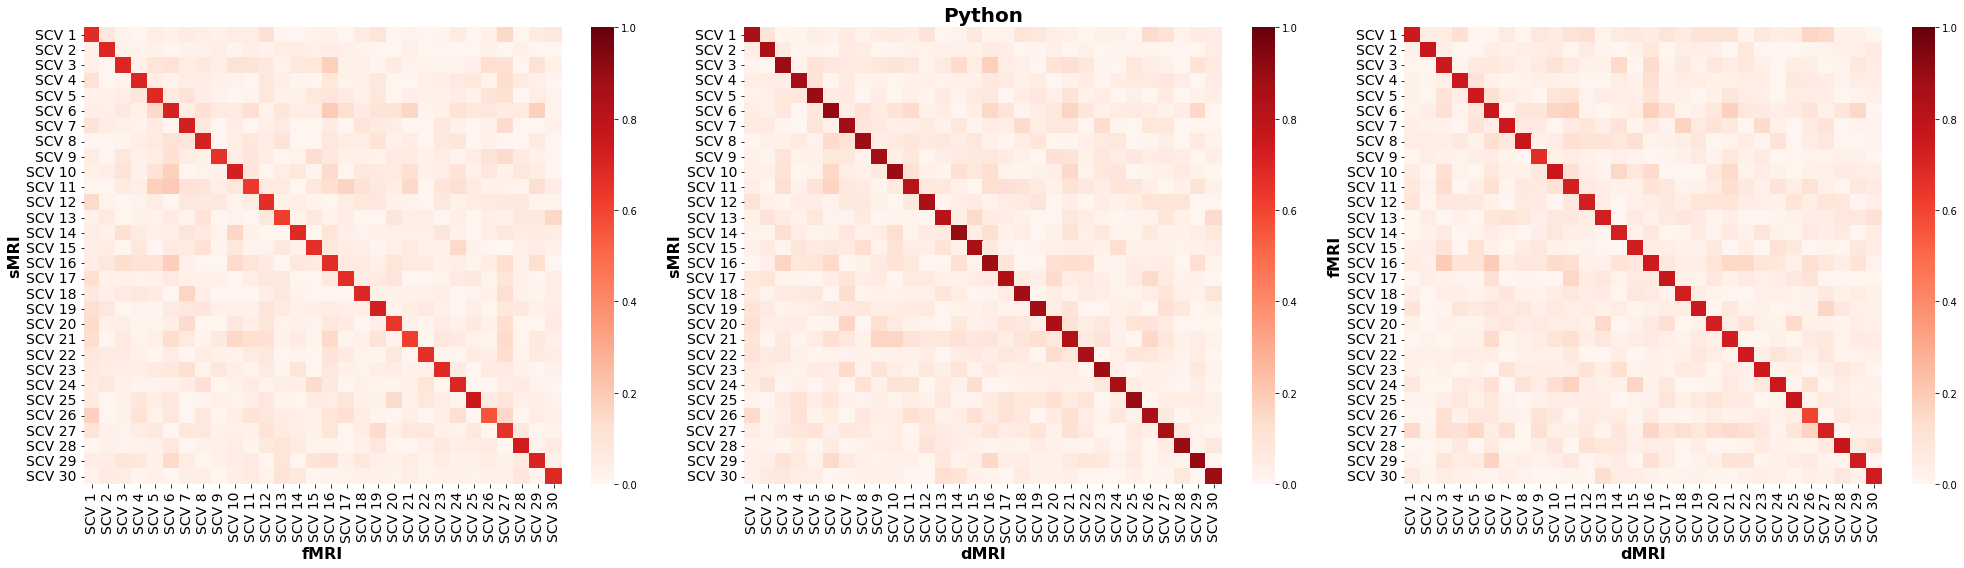

In [32]:
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
colormap_option = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28,8))

ticks = np.arange(0.5, 30.5, 1)
g1 = sns.heatmap(np.abs(corr_py_smri_fmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax1)
# g1.set_title("Python", fontsize=title_fontsize, fontweight="bold")
g1.set_xlabel("fMRI", fontsize=label_fontsize, fontweight="bold")
g1.set_xticks(ticks)
g1.set_xticklabels(g1.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g1.set_ylabel("sMRI", fontsize=label_fontsize, fontweight="bold")
g1.set_yticks(ticks)
g1.set_yticklabels(g1.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g2 = sns.heatmap(np.abs(corr_py_smri_dmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax2)
g2.set_title("Python", fontsize=title_fontsize, fontweight="bold")
g2.set_xlabel("dMRI", fontsize=label_fontsize, fontweight="bold")
g2.set_xticks(ticks)
g2.set_xticklabels(g2.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g2.set_ylabel("sMRI", fontsize=label_fontsize, fontweight="bold")
g2.set_yticks(ticks)
g2.set_yticklabels(g2.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

g3 = sns.heatmap(np.abs(corr_py_fmri_dmri), cmap=colormap_option, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=ax3)
# g3.set_title("Python", fontsize=title_fontsize, fontweight="bold")
g3.set_xlabel("dMRI", fontsize=label_fontsize, fontweight="bold")
g3.set_xticks(ticks)
g3.set_xticklabels(g3.get_xticklabels(), fontsize=tick_fontsize, rotation=90)
g3.set_ylabel("fMRI", fontsize=label_fontsize, fontweight="bold")
g3.set_yticks(ticks)
g3.set_yticklabels(g3.get_yticklabels(), fontsize=tick_fontsize, rotation=0)

plt.tight_layout()
plt.savefig("corr_recovered_sources_python.pdf", dpi=200)
files.download("corr_recovered_sources_python.pdf") 